#4. Salary Prediction Project - Data Modelling
by: Cindy Suyitno

Files that are used in this part:
- DataCleaned.csv (from part 3. Data Cleaning)

File that is extracted from this part:
- saved_model.pkl (--> will be used in part 5. Web App with Streamlit)

##4.1. Exploratory Data Analysis

In [56]:
#libraries that are used in this part
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from time import time
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.model_selection import RepeatedKFold

In [57]:
#calling the data using pandas
df = pd.read_csv('DataCleaned.csv')
df

,Job,Province,Min_Years,Max_Years,Min_Salary,Max_Salary
0,Art & Design,Jakarta,0,1,3250000.0,4650000.0
1,Sales,Jawa,0,0,3500000.0,5500000.0
2,Other,Jawa,0,1,3200000.0,4000000.0
3,Factory and Manufacturer,Jakarta,0,1,4000000.0,4285799.0
4,Hospitality & Travel,Jawa,0,0,6000000.0,7000000.0
...,...,...,...,...,...,...
5598,Factory and Manufacturer,Jawa,1,3,5000000.0,5500000.0
5599,Art & Design,Jakarta,1,3,4500000.0,6500000.0
5600,"Accounting, Finance, Banking",Jakarta,1,3,4641854.0,6000000.0
5601,Internet & New Media,Jawa,1,3,5000000.0,6000000.0


In [37]:
#checking anomaly values
df.describe()

,Min_Years,Max_Years,Min_Salary,Max_Salary
count,5603.000000,5603.000000,5.603000e+03,5.603000e+03
mean,1.267357,3.066750,4.100731e+07,6.494039e+07
std,1.393967,2.376212,2.148936e+09,3.542519e+09
min,0.000000,0.000000,0.000000e+00,2.000000e+00
25%,0.000000,1.000000,3.800000e+06,5.000000e+06
50%,1.000000,3.000000,5.000000e+06,7.000000e+06
75%,1.000000,3.000000,7.000000e+06,1.200000e+07
max,10.000000,20.000000,1.571072e+11,2.618453e+11


In [58]:
#cutting some outliers and deciding to use the mean of min-max salary and min-max years to represent the predictors
df['Salary'] = df[['Min_Salary','Max_Salary']].mean(axis=1)
df['Salary'][df['Salary'] > 50000000] = np.nan #outliers that are way too high
df['Years'] = df[['Min_Years','Max_Years']].mean(axis=1)
df = df.dropna(axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
#rechecking the values
df.describe()

,Min_Years,Max_Years,Min_Salary,Max_Salary,Salary,Years
count,5567.000000,5567.000000,5.567000e+03,5.567000e+03,5.567000e+03,5567.000000
mean,1.247350,3.029100,6.217344e+06,9.548883e+06,7.883113e+06,2.138225
std,1.352949,2.286491,4.819492e+06,7.901256e+06,6.119202e+06,1.805732
min,0.000000,0.000000,0.000000e+00,2.000000e+00,1.500000e+00,0.000000
25%,0.000000,1.000000,3.800000e+06,5.000000e+06,4.400000e+06,0.500000
50%,1.000000,3.000000,5.000000e+06,7.000000e+06,6.000000e+06,2.000000
75%,1.000000,3.000000,7.000000e+06,1.200000e+07,9.500000e+06,2.000000
max,10.000000,20.000000,5.000000e+07,8.100000e+07,5.000000e+07,15.000000


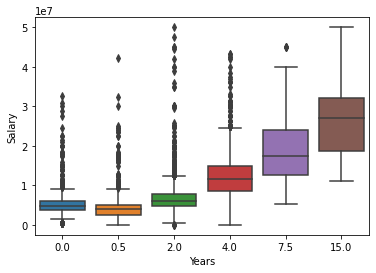

In [40]:
#checking the effect of years to salary
sns.boxplot(x=df['Years'],y=df['Salary'])

Since there are outliers in 0-4 years that is significantly different from the data median, especially in 0-1 years it is unlikely to have salary more than 10,000,000 hence most of these outliers will be replaced by median to avoid bias and inaccurate machine learning model.

In [59]:
df.loc[(df['Years']==0) & (df['Salary']>10000000),'Salary'] = df.loc[df['Years']==0]['Salary'].median()
df.loc[(df['Years']==0.5) & (df['Salary']>12500000),'Salary'] = df.loc[df['Years']==0.5]['Salary'].median()
df.loc[(df['Years']==2) & (df['Salary']>15000000),'Salary'] = df.loc[df['Years']==2]['Salary'].median()
df.loc[(df['Years']==4) & (df['Salary']>30000000),'Salary'] = df.loc[df['Years']==4]['Salary'].median()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

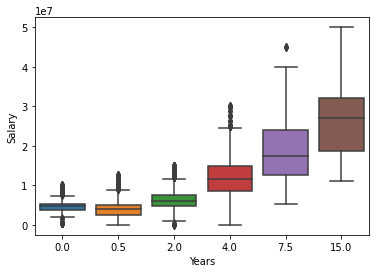

In [42]:
#final data
sns.boxplot(x=df['Years'],y=df['Salary'])

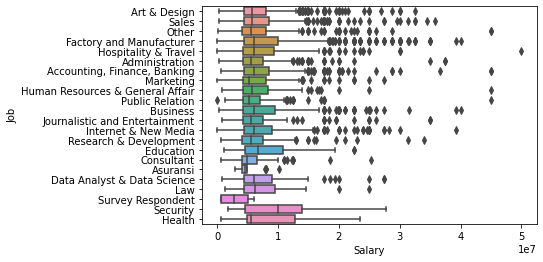

In [43]:
#checking the effect of job to salary
sns.boxplot(x=df['Salary'],y=df['Job'])

'Other' job is collection of jobs that not fit the particular job list that has made, hence it is reasonable to drop this value to avoid inaccuracy of our machine learning model.

In [60]:
df.loc[(df['Job']=='Other')] = np.nan
df = df.dropna(axis=0)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


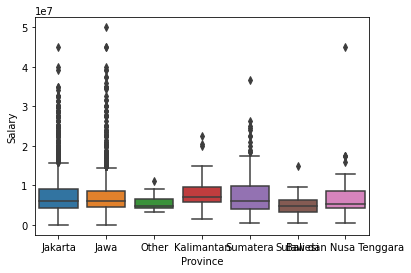

In [45]:
#checking the effect of province to salary
sns.boxplot(x=df['Province'],y=df['Salary'])

Province data may be varied and has outliers, but since this may be varied by job as well as years of experience, the data is considered valid and will be used as they are.

##4.2. Data Modelling

Regression model will be used in this project, since the prediction values is continuous. Models that are explored:
- Gradient Boosting Regressor
- K-Neighbors Regressor
- Extra Trees Regressor
- Random Forest Regressor
- Decision Tree Regressor
- Linear Regression
- Polynomial Regression
- Lasso
- Ridge

In [61]:
#transforming categorical data to numeric values
job_label = LabelEncoder()
df['Job_label'] = job_label.fit_transform(df['Job'])
province_label = LabelEncoder()
df['Province_label'] = province_label.fit_transform(df['Province'])

In [47]:
#begin to explore regression models
X = df[['Job_label','Years','Province_label']]
y = df['Salary']

sc = StandardScaler()
y_array = y.to_numpy()
y_array = y_array.reshape(-1, 1)
sc_X = sc.fit_transform(X)
sc_y = sc.fit_transform(y_array)
X_train, X_test, y_train, y_test = train_test_split(sc_X,sc_y, test_size=0.1, random_state=0)

regressors = [GradientBoostingRegressor(),
              KNeighborsRegressor(),
              ExtraTreesRegressor(),
              RandomForestRegressor(),
              DecisionTreeRegressor(),
              LinearRegression(),
              Lasso(),
              Ridge()]
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GradientBoostingRegressor()
	Training time: 0.141s
	Prediction time: 0.001s
	Explained variance: 0.5008408870017125
	Mean absolute error: 0.45334262996769475
	R2 score: 0.5006920771283044

KNeighborsRegressor()
	Training time: 0.003s
	Prediction time: 0.006s
	Explained variance: 0.3951908908193219
	Mean absolute error: 0.5023451323350342
	R2 score: 0.39436184213366776

ExtraTreesRegressor()
	Training time: 0.243s
	Prediction time: 0.019s
	Explained variance: 0.48655170087532096
	Mean absolute error: 0.46650726713333485
	R2 score: 0.4864772440114642



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor()
	Training time: 0.296s
	Prediction time: 0.020s
	Explained variance: 0.4775210891177398
	Mean absolute error: 0.4651108686431995
	R2 score: 0.47746979562831937

DecisionTreeRegressor()
	Training time: 0.006s
	Prediction time: 0.000s
	Explained variance: 0.48918104588683364
	Mean absolute error: 0.46485479842165295
	R2 score: 0.4891041725402342

LinearRegression()
	Training time: 0.005s
	Prediction time: 0.000s
	Explained variance: 0.4936332272729348
	Mean absolute error: 0.48336044250661203
	R2 score: 0.4932199195853345

Lasso()
	Training time: 0.007s
	Prediction time: 0.001s
	Explained variance: 0.0
	Mean absolute error: 0.6478674539086905
	R2 score: -7.992286610303267e-08

Ridge()
	Training time: 0.006s
	Prediction time: 0.001s
	Explained variance: 0.4936646502818105
	Mean absolute error: 0.48332951198534047
	R2 score: 0.49325150924811034



In [48]:
#Since the best model is between Linear Regression, Ridge, and GradientBoosting Regressor, these three models will be further explored
#Using hyperparameters to search best Linear Regression Model
model1 = LinearRegression()
space = dict()
space['n_jobs'] = [-1,1,3,5,10]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
space['copy_X'] = [True, False]
space['positive'] = [True, False]
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
search = GridSearchCV(model1, space, cv=cv, scoring='neg_mean_absolute_error')
result = search.fit(sc_X, sc_y)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Streaming output truncated to the last 5000 lines.

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **k

Best Score: -0.4925351142845757
Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'normalize': True, 'positive': True}


Explained variance: 0.4928874458746738
Sqrt mean absolute error: 1595.6153883432899
R2 score: 0.49236356705042916


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


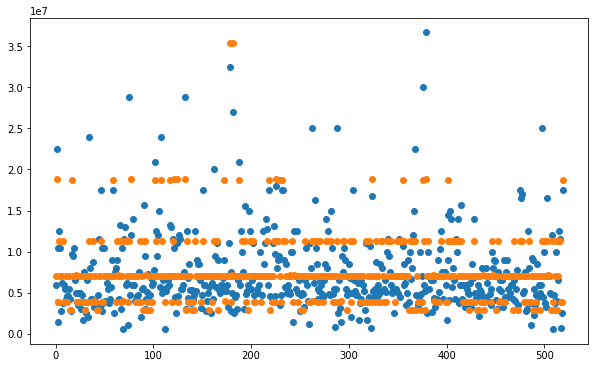

In [49]:
#Applying polynomial features to Linear Regression Model
X_train, X_test, y_train, y_test = train_test_split(sc_X,sc_y, test_size=0.1, random_state=0)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.1, random_state=0)
pol = PolynomialFeatures(degree=2)
pol_X = pol.fit_transform(X_train)
model1 = LinearRegression(copy_X= True, fit_intercept= False, n_jobs= -1, normalize= True, positive= True)
model1.fit(pol_X, y_train)
y_pred1 = sc.inverse_transform(model1.predict(pol.fit_transform(X_test)).reshape(-1,1))
print("Explained variance:", explained_variance_score(y_test1, y_pred1))
print("Sqrt mean absolute error:", np.sqrt(mean_absolute_error(y_test1, y_pred1)))
print("R2 score:", r2_score(y_test1, y_pred1))

#visualizing the predicted value (orange) with the real value (blue)
x = (range(len(X_test)))
fgr = plt.figure(figsize=(10, 6))
ax = fgr.add_subplot()
ax.scatter(x, y_test1)
ax.scatter(x,y_pred1)

In [50]:
#Using hyperparameters for Ridge Model
model2 = Ridge()
space = dict()
space['solver'] = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg','sag', 'saga', 'lbfgs']
space['alpha'] = [0.01, 0.1, 0.3, 0.5, 1]
space['normalize'] = [True, False]
space['positive'] = [True, False]
space['tol'] = [0.000001,0.000003,0.000005,0.00001]
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
search = GridSearchCV(model2, space, cv=cv, scoring='neg_mean_absolute_error')
result = search.fit(sc_X, sc_y)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Streaming output truncated to the last 5000 lines.

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: ori

Best Score: -0.48869925733103453
Best Hyperparameters: {'alpha': 0.1, 'normalize': True, 'positive': True, 'solver': 'auto', 'tol': 1e-06}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave 

Explained variance: 0.5010017366928317
Sqrt mean absolute error: 1578.9776406326475
R2 score: 0.5006361156588288


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


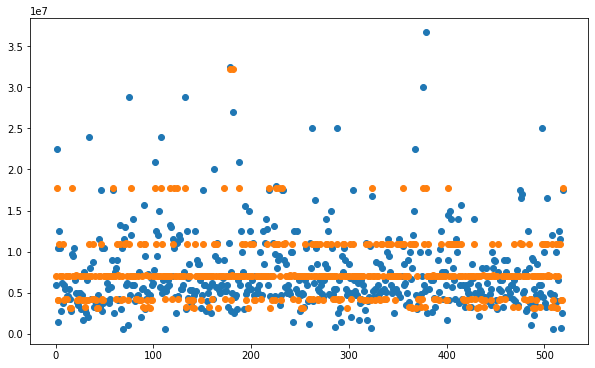

In [51]:
#Applying best fit to Ridge Model
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.1, random_state=0)

model2 = Ridge(alpha= 0.1, normalize= True, positive= True, solver= 'auto', tol= 1e-06)
model2.fit(X_train, y_train)
y_pred2 = sc.inverse_transform(model2.predict(X_test).reshape(-1,1))
print("Explained variance:", explained_variance_score(y_test1, y_pred2))
print("Sqrt mean absolute error:", np.sqrt(mean_absolute_error(y_test1, y_pred2)))
print("R2 score:", r2_score(y_test1, y_pred2))

#visualizing the predicted value (orange) with the real value (blue)
fgr = plt.figure(figsize=(10, 6))
ax = fgr.add_subplot()
ax.scatter(x, y_test1)
ax.scatter(x,y_pred2)

In [52]:
#Using hyperparameters for Gradient Boosting Regressor
model3 = GradientBoostingRegressor()
space = dict()
space['n_estimators'] = [1,3,5,10]
space['alpha'] = [0.00000001, 0.00001, 0.001, 0.1]
space['max_depth'] = [0.5,0.8,1,3]
space['learning_rate'] = [0.1,0.5,1,2]
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
search = GridSearchCV(model3, space, cv=cv, scoring='neg_mean_absolute_error')
result = search.fit(sc_X, sc_y)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

Best Score: -0.45831824995259457
Best Hyperparameters: {'alpha': 1e-08, 'learning_rate': 1, 'max_depth': 1, 'n_estimators': 5}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

Explained variance: 0.5174043824330457
Sqrt mean absolute error: 1527.1120307119618
R2 score: 0.5170536941083904


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


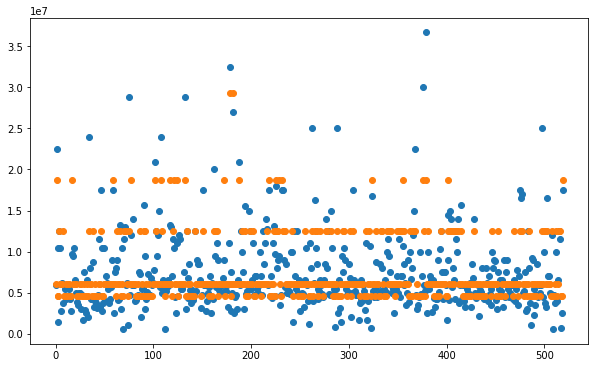

In [63]:
#Applying best fit to Gradient Boosting Regressor Model
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.1, random_state=0)

model3 = GradientBoostingRegressor(alpha= 1e-08, learning_rate= 1, max_depth= 1, n_estimators= 5)
model3.fit(X_train, y_train)
y_pred3 = sc.inverse_transform(model3.predict(X_test).reshape(-1,1))
print("Explained variance:", explained_variance_score(y_test1, y_pred3))
print("Sqrt mean absolute error:", np.sqrt(mean_absolute_error(y_test1, y_pred3)))
print("R2 score:", r2_score(y_test1, y_pred3))

#visualizing the predicted value (orange) with the real value (blue)
fgr = plt.figure(figsize=(10, 6))
ax = fgr.add_subplot()
ax.scatter(x, y_test1)
ax.scatter(x,y_pred3)

In [62]:
#table of comparison
df_comp = pd.DataFrame()
df_comp['Model'] = ['Polynomial Regression','Ridge','Gradient Boosting Regressor']
df_comp['Explained Variance Score'] = [explained_variance_score(y_test1, y_pred1),explained_variance_score(y_test1, y_pred2),explained_variance_score(y_test1, y_pred3)]
df_comp['Sqrt Mean Absolute Error'] = [np.sqrt(mean_absolute_error(y_test1, y_pred1)),np.sqrt(mean_absolute_error(y_test1, y_pred2)),np.sqrt(mean_absolute_error(y_test1, y_pred3))]
df_comp['r2 score'] = [r2_score(y_test1, y_pred1),r2_score(y_test1, y_pred2),r2_score(y_test1, y_pred3)]
df_comp

,Model,Explained Variance Score,Sqrt Mean Absolute Error,r2 score
0,Polynomial Regression,0.492887,1595.615388,0.492364
1,Ridge,0.501002,1578.977641,0.500636
2,Gradient Boosting Regressor,0.517404,1527.112031,0.517054


In [65]:
#Save the best model, alongside the job_label, years, sc, and dataframe
data = {'model': model3,'job_label':job_label, 'province_label':province_label, 'years':df['Years'], 'pol_reg':pol, 'sc':sc, 
        'df':df}
with open('saved_model.pkl','wb') as file:
  pickle.dump(data, file)